In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import operator
import matplotlib.pyplot as plt
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
'''
#Load data
csvfilename = 'SingleNotes_LowLevelFeatures.csv'
df = pd.read_csv(csvfilename)
df.head()
'''

"\n#Load data\ncsvfilename = 'SingleNotes_LowLevelFeatures.csv'\ndf = pd.read_csv(csvfilename)\ndf.head()\n"

In [3]:
def select_k_best(df, klass, n_features):
    ''' This method returns the two best features for the selected class, based on statistical tests, like ANOVA-f 
    test or mutual information
    '''
    #Divide de data in x and Y
    data_y = df[['Good-sound', 'Bad-attack', 'Bad-dynamics', 'Bad-pich', 'Bad-timber', 'Bad-richness']]
    X = df.iloc[:,:-6].values 
    Y = np.array(data_y)
    Y = Y.astype('int') 
    #Choose the klass to extract the features from
    Y = Y[:,klass]

    # feature extraction
    test = SelectKBest(score_func=mutual_info_classif, k=n_features)
    fit = test.fit(X, Y)
    # summarize scores
    feature_scores=fit.scores_

    #Select the two best scoring features
    index1, value = max(enumerate(feature_scores), key=operator.itemgetter(1))
    feature_scores[index1] = 0
    index2, value = max(enumerate(feature_scores), key=operator.itemgetter(1))

    #Save results
    feature1 = df.columns[index1]
    feature2 = df.columns[index2]
    on_klass = df.columns[klass-6]
   
    return feature1, feature2, on_klass

def select_RFE(df, klass, n_features):
    ''' This method returns the best n_features for the selected class, using Recursive Feature Elimination
    '''
    #Divide de data in x and Y
    data_y = df[['Good-sound', 'Bad-attack', 'Bad-dynamics', 'Bad-pich', 'Bad-timber', 'Bad-richness']]
    X = df.iloc[:,:-6].values 
    Y = np.array(data_y)
    Y = Y.astype('int') 
    #Choose the klass to extract the features from
    Y = Y[:,klass]
    
    # feature extraction
    #model = LogisticRegression(solver='lbfgs')
    model = svm.SVC(kernel='linear', probability = True)
    rfe = RFE(model, n_features_to_select = n_features)
    fit = rfe.fit(X, Y)
    
    #Save indexes where the value is true
    features_indexes = np.where(fit.support_)[0]
    
    #Save results
    features = []
    for i in range(n_features):
        features.append(df.columns[features_indexes[i]])

    on_klass = df.columns[klass-6]
    
    return features, on_klass

def write_to_file(features, on_klass):
    '''Write the name of the selected features to a desiered txt file with the name of the class'''
    #Write selected features to txt file
    folder = 'selected_features'
    filename = on_klass
    path = os.path.join(folder, filename)
    
    if os.path.exists(path+".txt"):
        os.remove(path+".txt")

    f = open(path+".txt","a")
    for feature in features:
        f.write(feature)
        f.write(",")    
    f.close()

In [4]:
csvfiles = ['extracted_features/Bad-attack_SingleNotes_LowLevelFeatures.csv', 'extracted_features/Good-sound_SingleNotes_LowLevelFeatures.csv']
df = pd.read_csv(csvfiles[0])
for x in csvfiles:
    print(x)
    

extracted_features/Bad-attack_SingleNotes_LowLevelFeatures.csv
extracted_features/Good-sound_SingleNotes_LowLevelFeatures.csv


In [5]:
#Extract the best n_features and compute the accuracy of the estimator
n_klasses = 6 #This is always 6
max_features = df.shape[1]-n_klasses #Do all features
accuracy = np.zeros((n_klasses, max_features,))

for klass in range(n_klasses):
    #Select the right reature set (klass==1 is bad attack)
    if klass == 1:
        df = pd.read_csv(csvfiles[0])
    else:
        df = pd.read_csv(csvfiles[1])
        
    for n_features in range(1, max_features):
        #Select the best n_features
        features, on_klass = select_RFE(df, klass, n_features)

        #sns.lmplot(x = feature1, y = feature2, data=df, hue=on_klass, fit_reg=False)    
        #plt.title(on_klass)
        #plt.show()

        #Create a df for each descriptor
        selected_features = df[features]
        descriptor = df[on_klass]
        selected_features = pd.concat([selected_features, descriptor], axis=1)

        #Write it to a CSV file
        folder = 'selected_features'
        path_to_selected_features = os.path.join(folder, on_klass)
        selected_features.to_csv(path_to_selected_features+'.csv')


        #Divide data in X and y
        X = np.array(df[features])
        y = np.array(df[on_klass])

        #Create SVM model
        model = svm.SVC(kernel='linear', probability = True)

        #Calculate accuracy with only two features
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
        clf = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[klass, n_features] = balanced_accuracy_score(y_test, y_pred)
        

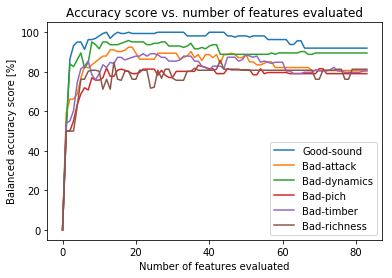

In [6]:
#Plot accuracy scores
descriptors = ['Good-sound', 'Bad-attack', 'Bad-dynamics', 'Bad-pich', 'Bad-timber', 'Bad-richness']
for i in range(n_klasses):
    plt.plot(accuracy[i,:]*100)
plt.legend(descriptors, loc = 4)
#plt.ylim(0,100)
plt.xlabel("Number of features evaluated")
plt.ylabel("Balanced accuracy score [%]")
plt.title("Accuracy score vs. number of features evaluated")
plt.style.use('seaborn-paper')
plt.savefig('saved_plots/FeatureSelection')
plt.show()

In [7]:
np.argmax(accuracy[0,:])

12

In [8]:
#Extract the optimal number of features for each descriptor and save them in a txt file
optimal_n_features = {}
for i in range(len(descriptors)):
    n_features = np.argmax(accuracy[i,:])
    
    if descriptors[i] == 'Bad-attack':
        df = pd.read_csv(csvfiles[0])
    else:
        df = pd.read_csv(csvfiles[1])
    
    #Find the best n_features names
    features, on_klass = select_RFE(df, i, n_features)
    
    #Write the selected features to a txt file
    write_to_file(features, on_klass)


In [9]:
#read the txt file
file = open("selected_features/Good-sound.txt", "r")
content = file.read()
content_list = content.split(",")
file.close()
content_list = content_list[:-1]
print(content_list)

['barkbands_flatness_db.mean', 'dissonance.mean', 'dynamic_complexity', 'loudness_ebu128.integrated', 'loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.mean', 'spectral_centroid.mean', 'spectral_decrease.stdev', 'spectral_energy.stdev', 'spectral_flux.mean', 'spectral_flux.stdev', 'spectral_spread.mean']


In [10]:
df[content_list]

,barkbands_flatness_db.mean,dissonance.mean,dynamic_complexity,loudness_ebu128.integrated,loudness_ebu128.momentary.mean,loudness_ebu128.short_term.mean,spectral_centroid.mean,spectral_decrease.stdev,spectral_energy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_spread.mean
0,-2.118541,0.301867,-1.132573,-0.102350,0.002810,0.009542,-0.747808,-1.415388,-1.430645,-0.612052,0.637697,-0.449337
1,-1.699127,-0.762735,-1.188337,0.375183,0.462675,0.586282,0.049313,-1.604622,-1.605603,-0.587253,0.325225,-0.812022
2,-1.022518,-1.344946,-1.131378,1.124131,1.187260,1.334433,-0.199765,-1.424878,-1.429788,-0.711449,0.255416,-1.135477
3,-0.833080,-1.317950,-1.262462,1.044814,1.114781,1.258195,-0.062841,-1.590709,-1.595875,-0.756815,0.185444,-1.484981
4,-1.373281,-0.457207,-1.361174,-0.187655,-0.077929,-0.009916,-0.656749,-1.554227,-1.577913,-0.160044,0.475031,-0.651241
...,...,...,...,...,...,...,...,...,...,...,...,...
319,1.821930,0.872153,1.315010,-0.311810,-0.487857,-0.396679,0.694275,1.092465,1.144571,-0.534356,-0.644069,-0.104547
320,1.256268,1.002526,0.190410,-0.859178,-0.852072,-0.722897,1.064824,0.370187,0.439409,-0.133241,-0.021249,0.003692
321,1.348623,1.101224,1.486856,-0.737634,-0.981410,-0.875245,1.205655,1.132515,1.209898,-0.339441,-0.567680,0.910398
322,1.164801,0.019434,3.424921,-0.202130,-0.603407,-0.235584,1.275536,1.409910,1.500617,-0.198717,-0.402839,2.382811


## Test for SVM

No handles with labels found to put in legend.


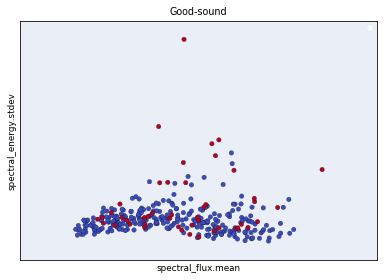

 Accuracy: 0.897196261682243
 Balanced Accuracy: 0.0


In [11]:
#Plot how the SVM separates the planes
klass=0
features, on_klass = select_RFE(df, klass, n_features = 2)
feature1 = features[0]
feature2 = features[1]
X = np.array(df[[feature1, feature2]])

y = np.array(df[['Good-sound', 'Bad-attack', 'Bad-dynamics', 'Bad-pich', 'Bad-timber', 'Bad-richness']])
y = y[:,i]

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

C = 1.0  # SVM regularization parameter
#model = svm.SVC(kernel='linear')

model = svm.SVC(kernel='linear', C=C)
#model = svm.SVC(kernel='rbf', gamma=0.7, C=C)
#model = svm.SVC(kernel='poly', degree=3, C=C)
#model = svm.LinearSVC(C=C)


clf = model.fit(X, y)

fig, ax = plt.subplots()
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.4)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel(feature1)
ax.set_xlabel(feature2)
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(on_klass)
ax.legend()
plt.show()

#Calculate accuracy with only two features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(" Accuracy:",accuracy_score(y_test, y_pred))
print(" Balanced Accuracy:",balanced_accuracy_score(y_test, y_pred, adjusted = True))